In [1]:
#Объявления нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import warnings
import os
from sklearn import preprocessing
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, model_selection
from xgboost import XGBClassifier
import itertools
import shutil
from sklearn.neural_network import MLPClassifier
import random



In [2]:
#Глобальные переменные
warnings.filterwarnings("ignore")
DATA_PATH = r"data/logs_k"
FEATURES = ["SP(мВ)","IK(мСм)", "GK(у.е.)"]
SPECIAL = ["DEPT(M)"]
TARGET = "KOLLEKTOR(unitless)"
PREDICT_COL = "KOLLEKTOR(out)"
RIGIS_BOT = "DBOT(M)"
DEPTH = "DEPT(M)"
REQ_FEATURES=FEATURES + SPECIAL + [TARGET]
FEATURE_SET = set(REQ_FEATURES)
IS_USED_DEVIANT = True

%matplotlib inline

CSV_FILES = {}
for file in os.listdir(DATA_PATH):
    if file.endswith(".csv"):
        CSV_FILES[file.split(".")[0]] = DATA_PATH + r"/" + file

In [3]:
#Функции
def rename_space(name):
    splits = name.split(' ')
    if(splits[0] == 'IK'):
        return "IK(мСм)"
    if splits[0].startswith('КС1'):
        return "КС1(A0 4M0.1N)(unitless)"
    if (splits[0].strip() == "WNK"):
        return "WNK()"
    if len(splits) == 1 or splits[1].strip() == "":
        return "{0}({1})".format(splits[0].strip(), "unitless")
    return "{0}({1})".format(splits[0].strip(), splits[1].strip())


def calc_well(well, file, alg):
    frame = pd.read_csv(CSV_FILES[well], sep=";")
    acc = -1
    frame = frame.rename(columns=rename_space)
    if FEATURE_SET.issubset(set(list(frame.columns))):
        frame = frame[REQ_FEATURES]
        frame = frame[np.isfinite(frame[TARGET])]
        frame = frame.dropna()
        if len(frame.index)  == 0:
            return
        if IS_USED_DEVIANT:
            frame = set_deviant(frame)
        frame = norm_frame(frame)
        model_predictions = alg.predict(frame[FEATURES].values)
        frame[PREDICT_COL] = model_predictions
        #restore_collectors(frame, avg_height)
        acc = metrics.accuracy_score(frame[[TARGET]], frame[[PREDICT_COL]])

        dirs = "data\\out\\"+ alg.__class__.__name__ 
        if not os.path.exists(dirs):
            os.makedirs(dirs)
        frame[RIGIS_BOT] = frame[DEPTH] + 0.1 
        frame.to_csv("data\\out\\"+ alg.__class__.__name__  + "\\" + well + ".csv", sep=';', mode="w+")
        return acc

    
def norm_frame(fr):
    scaler = preprocessing.MinMaxScaler()
    x = fr[FEATURES].values #returns a numpy array
    x_scaled = scaler.fit_transform(x)
    r = pd.DataFrame(x_scaled,columns=FEATURES, index=fr.index)
    for spec in SPECIAL:
        r[spec] = fr[spec]
    r[TARGET] = fr[TARGET]
    return r
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def set_deviant(frame):
    frame["DEVIANT"] = abs(frame["SP(мВ)"] - frame["IK(мСм)"])
    if "DEVIANT" not in FEATURES:
        FEATURES.append("DEVIANT")
        REQ_FEATURES=FEATURES + SPECIAL + [TARGET]
        FEATURE_SET = set(REQ_FEATURES)
    return frame
    
    

In [4]:
#формирование обучающей выборки
WELLS =list(random.sample(CSV_FILES.keys(), 50))
print(WELLS)
FRAMES = []
for w in WELLS:
    if w not in CSV_FILES:
        continue
    frame_buf = pd.read_csv(CSV_FILES[w], sep=";")
    frame_buf=frame_buf.rename(columns=rename_space)
    if FEATURE_SET.issubset(set(list(frame_buf.columns))):
        frame_buf = frame_buf[REQ_FEATURES]
        frame_buf = frame_buf[np.isfinite(frame_buf[TARGET])]
        frame_buf= frame_buf.dropna()
        frame_buf.info()
        FRAMES.append(frame_buf)

FRAME = pd.concat(FRAMES)
FRAME.info()

['5955', '6913', '9131', '6932', '5732', '9162', '5244', '6472', '8601g', '7041', '7125', '9288', '5503', '6482', '6933', '8534', '6307', '5715', '6423', '5581', '5824', '6221', '8206', '8615', '8627', '5231', '8456', '5892', '5965', '6923', '5932', '6344', '9122o', '5902', '9339', '6904', '5574', '9141', '7136', '9217', '8245', '5236', '5952', '6432', '5535', '8048', '5933', '9436', '8266', '5843']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 17 to 580
Data columns (total 5 columns):
SP(мВ)                 564 non-null float64
IK(мСм)                564 non-null float64
GK(у.е.)               564 non-null float64
DEPT(M)                564 non-null float64
KOLLEKTOR(unitless)    564 non-null float64
dtypes: float64(5)
memory usage: 26.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1351 entries, 0 to 1350
Data columns (total 5 columns):
SP(мВ)                 1351 non-null float64
IK(мСм)                1351 non-null float64
GK(у.е.)               1351 non-nul

In [5]:
if IS_USED_DEVIANT:
    FRAME = set_deviant(FRAME)
FRAME = norm_frame(FRAME)
FRAME

,SP(мВ),IK(мСм),GK(у.е.),DEVIANT,DEPT(M),KOLLEKTOR(unitless)
17,0.524066,0.427098,0.019590,0.253250,2690.7,0.0
18,0.535362,0.422194,0.020535,0.242370,2690.8,0.0
19,0.535956,0.421158,0.021555,0.240638,2690.9,0.0
20,0.536550,0.430586,0.022579,0.254488,2691.0,0.0
21,0.521179,0.437942,0.022642,0.270310,2691.1,0.0
22,0.505844,0.440470,0.022704,0.278932,2691.2,0.0
23,0.490473,0.440243,0.022453,0.283463,2691.3,0.0
24,0.475138,0.430940,0.022201,0.274472,2691.4,0.0
25,0.485888,0.423281,0.022752,0.259663,2691.5,0.0
26,0.496638,0.420374,0.023302,0.251929,2691.6,0.0


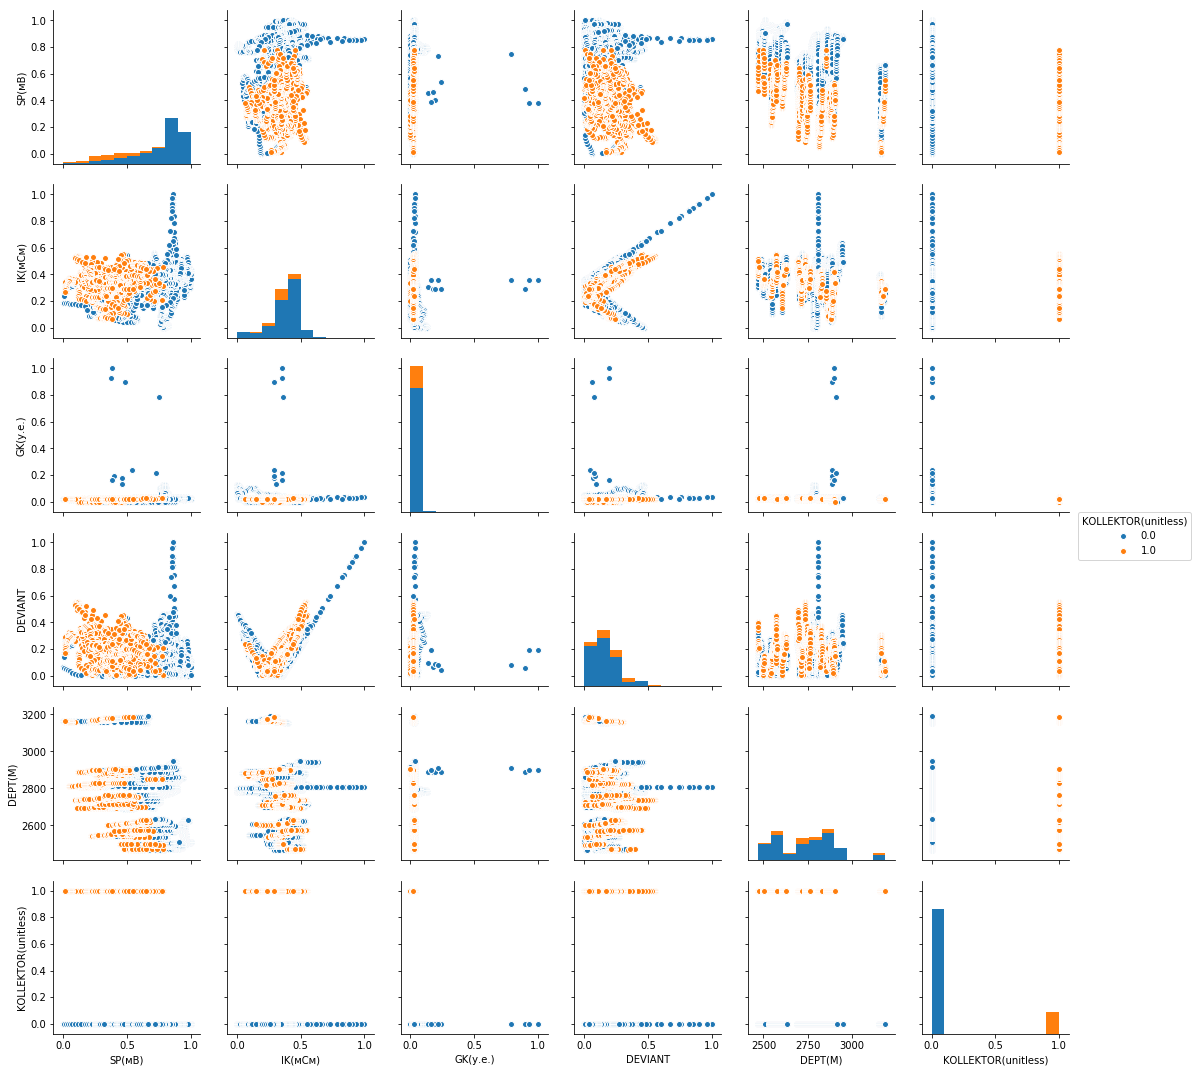

In [6]:
sn = sns.pairplot(FRAME, hue=TARGET)

In [7]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
      #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    ensemble.BaggingClassifier(),
    
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #SVM
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
        
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier(),
    
    
     #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True, nu=0.001),
    svm.LinearSVC(),
    MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 3, 1), random_state=1)
    
    ]

In [8]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = FRAME[[TARGET]]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, FRAME[FEATURES].values, FRAME[[TARGET]].values, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    print(cv_results['train_score'])
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(FRAME[FEATURES].values, FRAME[[TARGET]].values)
    MLA_predict[MLA_name] = alg.predict(FRAME[FEATURES].values)
    
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

[0.91026174 0.91358538 0.90735355 0.90735355 0.91067719 0.90486082
 0.90735355 0.9092231  0.90756128 0.90963855]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.93622767 0.9349813  0.93560449 0.9326963  0.93851267 0.93622767
 0.93228085 0.93705858 0.9349813  0.93394267]
[0.99314499 0.99605318 0.99231408 0.99543    0.99543    0.99335272
 0.99501454 0.99418363 0.99252181 0.99293727]
[0.99501454 0.99439136 0.99210636 0.99522227 0.99314499 0.99480681
 0.99272954 0.99252181 0.99418363 0.99439136]
[0.94245949 0.94640631 0.94245949 0.94432904 0.94266722 0.93830494
 0.93664312 0.94245949 0.93996676 0.94225177]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.88990445 0.89281263 0.88180307 0.8926049  0.8948899  0.89177399
 0.89094308 0.88741172 0.89135854 0.8880349 ]
[0.88741172 0.89405899 0.89135854 0.89364354 0.88658081 0.88845035
 0.8903199  0.89156627 0.88138762 0.88990445]
[0.92521811 0.93144994 0.92168675 0.92459493 0.93248857 0.9281263
 0.92189447 0.92729539 0.92334857 0.92604902]
[

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
1,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1,0.921387,0.00987368,0.0253014
4,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.993851,0.919477,0.0130243,0.0843049
3,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.994038,0.917733,0.0106219,0.0568033
5,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.941795,0.912666,0.0103944,0.00400023
2,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.935251,0.911337,0.010457,0.247214
10,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.926215,0.91005,0.0105596,0.160309
6,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.904277,0.00805958,0.0124007
7,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.901744,0.0181501,0.00200012
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.908787,0.897841,0.0142376,0.208712
11,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.891649,0.89348,0.0189864,0.925053


In [9]:
if os.path.exists("data\\out"):
    shutil.rmtree("data\\out")
result_by_wells = { 'MLA Name':[], 'Well' : [], 'Acc':[] }
total = len(MLA) * len(CSV_FILES)
cur = 0.0
selected_wells = list(CSV_FILES.keys())
for well, file in CSV_FILES.items():
    if well not in selected_wells:
        continue
    for alg in MLA:
        cur = cur + 1
        print(well + "/" + alg.__class__.__name__)
        acc = calc_well(well, file, alg)
        if not acc is None:
            result_by_wells['MLA Name'].append(alg.__class__.__name__)
            result_by_wells['Well'].append(well)
            result_by_wells['Acc'].append(acc)

result_by_wells_frame = pd.DataFrame.from_dict(result_by_wells)

5211/AdaBoostClassifier
5211/ExtraTreesClassifier
5211/GradientBoostingClassifier
5211/RandomForestClassifier
5211/BaggingClassifier
5211/KNeighborsClassifier
5211/DecisionTreeClassifier
5211/ExtraTreeClassifier
5211/SGDClassifier
5211/Perceptron
5211/XGBClassifier
5211/SVC
5211/NuSVC
5211/LinearSVC
5211/MLPClassifier
5212/AdaBoostClassifier
5212/ExtraTreesClassifier
5212/GradientBoostingClassifier
5212/RandomForestClassifier
5212/BaggingClassifier
5212/KNeighborsClassifier
5212/DecisionTreeClassifier
5212/ExtraTreeClassifier
5212/SGDClassifier
5212/Perceptron
5212/XGBClassifier
5212/SVC
5212/NuSVC
5212/LinearSVC
5212/MLPClassifier
5213/AdaBoostClassifier
5213/ExtraTreesClassifier
5213/GradientBoostingClassifier
5213/RandomForestClassifier
5213/BaggingClassifier
5213/KNeighborsClassifier
5213/DecisionTreeClassifier
5213/ExtraTreeClassifier
5213/SGDClassifier
5213/Perceptron
5213/XGBClassifier
5213/SVC
5213/NuSVC
5213/LinearSVC
5213/MLPClassifier
5214/AdaBoostClassifier
5214/ExtraTreesC

5256/BaggingClassifier
5256/KNeighborsClassifier
5256/DecisionTreeClassifier
5256/ExtraTreeClassifier
5256/SGDClassifier
5256/Perceptron
5256/XGBClassifier
5256/SVC
5256/NuSVC
5256/LinearSVC
5256/MLPClassifier
5272/AdaBoostClassifier
5272/ExtraTreesClassifier
5272/GradientBoostingClassifier
5272/RandomForestClassifier
5272/BaggingClassifier
5272/KNeighborsClassifier
5272/DecisionTreeClassifier
5272/ExtraTreeClassifier
5272/SGDClassifier
5272/Perceptron
5272/XGBClassifier
5272/SVC
5272/NuSVC
5272/LinearSVC
5272/MLPClassifier
5273/AdaBoostClassifier
5273/ExtraTreesClassifier
5273/GradientBoostingClassifier
5273/RandomForestClassifier
5273/BaggingClassifier
5273/KNeighborsClassifier
5273/DecisionTreeClassifier
5273/ExtraTreeClassifier
5273/SGDClassifier
5273/Perceptron
5273/XGBClassifier
5273/SVC
5273/NuSVC
5273/LinearSVC
5273/MLPClassifier
5501/AdaBoostClassifier
5501/ExtraTreesClassifier
5501/GradientBoostingClassifier
5501/RandomForestClassifier
5501/BaggingClassifier
5501/KNeighborsCl

5713/ExtraTreesClassifier
5713/GradientBoostingClassifier
5713/RandomForestClassifier
5713/BaggingClassifier
5713/KNeighborsClassifier
5713/DecisionTreeClassifier
5713/ExtraTreeClassifier
5713/SGDClassifier
5713/Perceptron
5713/XGBClassifier
5713/SVC
5713/NuSVC
5713/LinearSVC
5713/MLPClassifier
5714/AdaBoostClassifier
5714/ExtraTreesClassifier
5714/GradientBoostingClassifier
5714/RandomForestClassifier
5714/BaggingClassifier
5714/KNeighborsClassifier
5714/DecisionTreeClassifier
5714/ExtraTreeClassifier
5714/SGDClassifier
5714/Perceptron
5714/XGBClassifier
5714/SVC
5714/NuSVC
5714/LinearSVC
5714/MLPClassifier
5715/AdaBoostClassifier
5715/ExtraTreesClassifier
5715/GradientBoostingClassifier
5715/RandomForestClassifier
5715/BaggingClassifier
5715/KNeighborsClassifier
5715/DecisionTreeClassifier
5715/ExtraTreeClassifier
5715/SGDClassifier
5715/Perceptron
5715/XGBClassifier
5715/SVC
5715/NuSVC
5715/LinearSVC
5715/MLPClassifier
5716/AdaBoostClassifier
5716/ExtraTreesClassifier
5716/GradientB

5802l/KNeighborsClassifier
5802l/DecisionTreeClassifier
5802l/ExtraTreeClassifier
5802l/SGDClassifier
5802l/Perceptron
5802l/XGBClassifier
5802l/SVC
5802l/NuSVC
5802l/LinearSVC
5802l/MLPClassifier
5811/AdaBoostClassifier
5811/ExtraTreesClassifier
5811/GradientBoostingClassifier
5811/RandomForestClassifier
5811/BaggingClassifier
5811/KNeighborsClassifier
5811/DecisionTreeClassifier
5811/ExtraTreeClassifier
5811/SGDClassifier
5811/Perceptron
5811/XGBClassifier
5811/SVC
5811/NuSVC
5811/LinearSVC
5811/MLPClassifier
5812/AdaBoostClassifier
5812/ExtraTreesClassifier
5812/GradientBoostingClassifier
5812/RandomForestClassifier
5812/BaggingClassifier
5812/KNeighborsClassifier
5812/DecisionTreeClassifier
5812/ExtraTreeClassifier
5812/SGDClassifier
5812/Perceptron
5812/XGBClassifier
5812/SVC
5812/NuSVC
5812/LinearSVC
5812/MLPClassifier
5813/AdaBoostClassifier
5813/ExtraTreesClassifier
5813/GradientBoostingClassifier
5813/RandomForestClassifier
5813/BaggingClassifier
5813/KNeighborsClassifier
5813

5897/KNeighborsClassifier
5897/DecisionTreeClassifier
5897/ExtraTreeClassifier
5897/SGDClassifier
5897/Perceptron
5897/XGBClassifier
5897/SVC
5897/NuSVC
5897/LinearSVC
5897/MLPClassifier
5901/AdaBoostClassifier
5901/ExtraTreesClassifier
5901/GradientBoostingClassifier
5901/RandomForestClassifier
5901/BaggingClassifier
5901/KNeighborsClassifier
5901/DecisionTreeClassifier
5901/ExtraTreeClassifier
5901/SGDClassifier
5901/Perceptron
5901/XGBClassifier
5901/SVC
5901/NuSVC
5901/LinearSVC
5901/MLPClassifier
5901l/AdaBoostClassifier
5901l/ExtraTreesClassifier
5901l/GradientBoostingClassifier
5901l/RandomForestClassifier
5901l/BaggingClassifier
5901l/KNeighborsClassifier
5901l/DecisionTreeClassifier
5901l/ExtraTreeClassifier
5901l/SGDClassifier
5901l/Perceptron
5901l/XGBClassifier
5901l/SVC
5901l/NuSVC
5901l/LinearSVC
5901l/MLPClassifier
5902/AdaBoostClassifier
5902/ExtraTreesClassifier
5902/GradientBoostingClassifier
5902/RandomForestClassifier
5902/BaggingClassifier
5902/KNeighborsClassifier

5953/XGBClassifier
5953/SVC
5953/NuSVC
5953/LinearSVC
5953/MLPClassifier
5954/AdaBoostClassifier
5954/ExtraTreesClassifier
5954/GradientBoostingClassifier
5954/RandomForestClassifier
5954/BaggingClassifier
5954/KNeighborsClassifier
5954/DecisionTreeClassifier
5954/ExtraTreeClassifier
5954/SGDClassifier
5954/Perceptron
5954/XGBClassifier
5954/SVC
5954/NuSVC
5954/LinearSVC
5954/MLPClassifier
5955/AdaBoostClassifier
5955/ExtraTreesClassifier
5955/GradientBoostingClassifier
5955/RandomForestClassifier
5955/BaggingClassifier
5955/KNeighborsClassifier
5955/DecisionTreeClassifier
5955/ExtraTreeClassifier
5955/SGDClassifier
5955/Perceptron
5955/XGBClassifier
5955/SVC
5955/NuSVC
5955/LinearSVC
5955/MLPClassifier
5956/AdaBoostClassifier
5956/ExtraTreesClassifier
5956/GradientBoostingClassifier
5956/RandomForestClassifier
5956/BaggingClassifier
5956/KNeighborsClassifier
5956/DecisionTreeClassifier
5956/ExtraTreeClassifier
5956/SGDClassifier
5956/Perceptron
5956/XGBClassifier
5956/SVC
5956/NuSVC
5

6223/GradientBoostingClassifier
6223/RandomForestClassifier
6223/BaggingClassifier
6223/KNeighborsClassifier
6223/DecisionTreeClassifier
6223/ExtraTreeClassifier
6223/SGDClassifier
6223/Perceptron
6223/XGBClassifier
6223/SVC
6223/NuSVC
6223/LinearSVC
6223/MLPClassifier
6224/AdaBoostClassifier
6224/ExtraTreesClassifier
6224/GradientBoostingClassifier
6224/RandomForestClassifier
6224/BaggingClassifier
6224/KNeighborsClassifier
6224/DecisionTreeClassifier
6224/ExtraTreeClassifier
6224/SGDClassifier
6224/Perceptron
6224/XGBClassifier
6224/SVC
6224/NuSVC
6224/LinearSVC
6224/MLPClassifier
6232/AdaBoostClassifier
6232/ExtraTreesClassifier
6232/GradientBoostingClassifier
6232/RandomForestClassifier
6232/BaggingClassifier
6232/KNeighborsClassifier
6232/DecisionTreeClassifier
6232/ExtraTreeClassifier
6232/SGDClassifier
6232/Perceptron
6232/XGBClassifier
6232/SVC
6232/NuSVC
6232/LinearSVC
6232/MLPClassifier
6233/AdaBoostClassifier
6233/ExtraTreesClassifier
6233/GradientBoostingClassifier
6233/Ran

6316/RandomForestClassifier
6316/BaggingClassifier
6316/KNeighborsClassifier
6316/DecisionTreeClassifier
6316/ExtraTreeClassifier
6316/SGDClassifier
6316/Perceptron
6316/XGBClassifier
6316/SVC
6316/NuSVC
6316/LinearSVC
6316/MLPClassifier
6317/AdaBoostClassifier
6317/ExtraTreesClassifier
6317/GradientBoostingClassifier
6317/RandomForestClassifier
6317/BaggingClassifier
6317/KNeighborsClassifier
6317/DecisionTreeClassifier
6317/ExtraTreeClassifier
6317/SGDClassifier
6317/Perceptron
6317/XGBClassifier
6317/SVC
6317/NuSVC
6317/LinearSVC
6317/MLPClassifier
6318/AdaBoostClassifier
6318/ExtraTreesClassifier
6318/GradientBoostingClassifier
6318/RandomForestClassifier
6318/BaggingClassifier
6318/KNeighborsClassifier
6318/DecisionTreeClassifier
6318/ExtraTreeClassifier
6318/SGDClassifier
6318/Perceptron
6318/XGBClassifier
6318/SVC
6318/NuSVC
6318/LinearSVC
6318/MLPClassifier
6319/AdaBoostClassifier
6319/ExtraTreesClassifier
6319/GradientBoostingClassifier
6319/RandomForestClassifier
6319/Bagging

6377/LinearSVC
6377/MLPClassifier
6401/AdaBoostClassifier
6401/ExtraTreesClassifier
6401/GradientBoostingClassifier
6401/RandomForestClassifier
6401/BaggingClassifier
6401/KNeighborsClassifier
6401/DecisionTreeClassifier
6401/ExtraTreeClassifier
6401/SGDClassifier
6401/Perceptron
6401/XGBClassifier
6401/SVC
6401/NuSVC
6401/LinearSVC
6401/MLPClassifier
6402/AdaBoostClassifier
6402/ExtraTreesClassifier
6402/GradientBoostingClassifier
6402/RandomForestClassifier
6402/BaggingClassifier
6402/KNeighborsClassifier
6402/DecisionTreeClassifier
6402/ExtraTreeClassifier
6402/SGDClassifier
6402/Perceptron
6402/XGBClassifier
6402/SVC
6402/NuSVC
6402/LinearSVC
6402/MLPClassifier
6411/AdaBoostClassifier
6411/ExtraTreesClassifier
6411/GradientBoostingClassifier
6411/RandomForestClassifier
6411/BaggingClassifier
6411/KNeighborsClassifier
6411/DecisionTreeClassifier
6411/ExtraTreeClassifier
6411/SGDClassifier
6411/Perceptron
6411/XGBClassifier
6411/SVC
6411/NuSVC
6411/LinearSVC
6411/MLPClassifier
6412/A

6482/ExtraTreeClassifier
6482/SGDClassifier
6482/Perceptron
6482/XGBClassifier
6482/SVC
6482/NuSVC
6482/LinearSVC
6482/MLPClassifier
6483/AdaBoostClassifier
6483/ExtraTreesClassifier
6483/GradientBoostingClassifier
6483/RandomForestClassifier
6483/BaggingClassifier
6483/KNeighborsClassifier
6483/DecisionTreeClassifier
6483/ExtraTreeClassifier
6483/SGDClassifier
6483/Perceptron
6483/XGBClassifier
6483/SVC
6483/NuSVC
6483/LinearSVC
6483/MLPClassifier
6484/AdaBoostClassifier
6484/ExtraTreesClassifier
6484/GradientBoostingClassifier
6484/RandomForestClassifier
6484/BaggingClassifier
6484/KNeighborsClassifier
6484/DecisionTreeClassifier
6484/ExtraTreeClassifier
6484/SGDClassifier
6484/Perceptron
6484/XGBClassifier
6484/SVC
6484/NuSVC
6484/LinearSVC
6484/MLPClassifier
6505/AdaBoostClassifier
6505/ExtraTreesClassifier
6505/GradientBoostingClassifier
6505/RandomForestClassifier
6505/BaggingClassifier
6505/KNeighborsClassifier
6505/DecisionTreeClassifier
6505/ExtraTreeClassifier
6505/SGDClassif

6904/NuSVC
6904/LinearSVC
6904/MLPClassifier
6906/AdaBoostClassifier
6906/ExtraTreesClassifier
6906/GradientBoostingClassifier
6906/RandomForestClassifier
6906/BaggingClassifier
6906/KNeighborsClassifier
6906/DecisionTreeClassifier
6906/ExtraTreeClassifier
6906/SGDClassifier
6906/Perceptron
6906/XGBClassifier
6906/SVC
6906/NuSVC
6906/LinearSVC
6906/MLPClassifier
6913/AdaBoostClassifier
6913/ExtraTreesClassifier
6913/GradientBoostingClassifier
6913/RandomForestClassifier
6913/BaggingClassifier
6913/KNeighborsClassifier
6913/DecisionTreeClassifier
6913/ExtraTreeClassifier
6913/SGDClassifier
6913/Perceptron
6913/XGBClassifier
6913/SVC
6913/NuSVC
6913/LinearSVC
6913/MLPClassifier
6923/AdaBoostClassifier
6923/ExtraTreesClassifier
6923/GradientBoostingClassifier
6923/RandomForestClassifier
6923/BaggingClassifier
6923/KNeighborsClassifier
6923/DecisionTreeClassifier
6923/ExtraTreeClassifier
6923/SGDClassifier
6923/Perceptron
6923/XGBClassifier
6923/SVC
6923/NuSVC
6923/LinearSVC
6923/MLPClassi

7053/DecisionTreeClassifier
7053/ExtraTreeClassifier
7053/SGDClassifier
7053/Perceptron
7053/XGBClassifier
7053/SVC
7053/NuSVC
7053/LinearSVC
7053/MLPClassifier
7054/AdaBoostClassifier
7054/ExtraTreesClassifier
7054/GradientBoostingClassifier
7054/RandomForestClassifier
7054/BaggingClassifier
7054/KNeighborsClassifier
7054/DecisionTreeClassifier
7054/ExtraTreeClassifier
7054/SGDClassifier
7054/Perceptron
7054/XGBClassifier
7054/SVC
7054/NuSVC
7054/LinearSVC
7054/MLPClassifier
7055/AdaBoostClassifier
7055/ExtraTreesClassifier
7055/GradientBoostingClassifier
7055/RandomForestClassifier
7055/BaggingClassifier
7055/KNeighborsClassifier
7055/DecisionTreeClassifier
7055/ExtraTreeClassifier
7055/SGDClassifier
7055/Perceptron
7055/XGBClassifier
7055/SVC
7055/NuSVC
7055/LinearSVC
7055/MLPClassifier
7056/AdaBoostClassifier
7056/ExtraTreesClassifier
7056/GradientBoostingClassifier
7056/RandomForestClassifier
7056/BaggingClassifier
7056/KNeighborsClassifier
7056/DecisionTreeClassifier
7056/ExtraTr

7193/SGDClassifier
7193/Perceptron
7193/XGBClassifier
7193/SVC
7193/NuSVC
7193/LinearSVC
7193/MLPClassifier
7194/AdaBoostClassifier
7194/ExtraTreesClassifier
7194/GradientBoostingClassifier
7194/RandomForestClassifier
7194/BaggingClassifier
7194/KNeighborsClassifier
7194/DecisionTreeClassifier
7194/ExtraTreeClassifier
7194/SGDClassifier
7194/Perceptron
7194/XGBClassifier
7194/SVC
7194/NuSVC
7194/LinearSVC
7194/MLPClassifier
7245/AdaBoostClassifier
7245/ExtraTreesClassifier
7245/GradientBoostingClassifier
7245/RandomForestClassifier
7245/BaggingClassifier
7245/KNeighborsClassifier
7245/DecisionTreeClassifier
7245/ExtraTreeClassifier
7245/SGDClassifier
7245/Perceptron
7245/XGBClassifier
7245/SVC
7245/NuSVC
7245/LinearSVC
7245/MLPClassifier
7256/AdaBoostClassifier
7256/ExtraTreesClassifier
7256/GradientBoostingClassifier
7256/RandomForestClassifier
7256/BaggingClassifier
7256/KNeighborsClassifier
7256/DecisionTreeClassifier
7256/ExtraTreeClassifier
7256/SGDClassifier
7256/Perceptron
7256/

8225/MLPClassifier
8226/AdaBoostClassifier
8226/ExtraTreesClassifier
8226/GradientBoostingClassifier
8226/RandomForestClassifier
8226/BaggingClassifier
8226/KNeighborsClassifier
8226/DecisionTreeClassifier
8226/ExtraTreeClassifier
8226/SGDClassifier
8226/Perceptron
8226/XGBClassifier
8226/SVC
8226/NuSVC
8226/LinearSVC
8226/MLPClassifier
8234/AdaBoostClassifier
8234/ExtraTreesClassifier
8234/GradientBoostingClassifier
8234/RandomForestClassifier
8234/BaggingClassifier
8234/KNeighborsClassifier
8234/DecisionTreeClassifier
8234/ExtraTreeClassifier
8234/SGDClassifier
8234/Perceptron
8234/XGBClassifier
8234/SVC
8234/NuSVC
8234/LinearSVC
8234/MLPClassifier
8235/AdaBoostClassifier
8235/ExtraTreesClassifier
8235/GradientBoostingClassifier
8235/RandomForestClassifier
8235/BaggingClassifier
8235/KNeighborsClassifier
8235/DecisionTreeClassifier
8235/ExtraTreeClassifier
8235/SGDClassifier
8235/Perceptron
8235/XGBClassifier
8235/SVC
8235/NuSVC
8235/LinearSVC
8235/MLPClassifier
8236/AdaBoostClassifi

8354/XGBClassifier
8354/SVC
8354/NuSVC
8354/LinearSVC
8354/MLPClassifier
8362/AdaBoostClassifier
8362/ExtraTreesClassifier
8362/GradientBoostingClassifier
8362/RandomForestClassifier
8362/BaggingClassifier
8362/KNeighborsClassifier
8362/DecisionTreeClassifier
8362/ExtraTreeClassifier
8362/SGDClassifier
8362/Perceptron
8362/XGBClassifier
8362/SVC
8362/NuSVC
8362/LinearSVC
8362/MLPClassifier
8363/AdaBoostClassifier
8363/ExtraTreesClassifier
8363/GradientBoostingClassifier
8363/RandomForestClassifier
8363/BaggingClassifier
8363/KNeighborsClassifier
8363/DecisionTreeClassifier
8363/ExtraTreeClassifier
8363/SGDClassifier
8363/Perceptron
8363/XGBClassifier
8363/SVC
8363/NuSVC
8363/LinearSVC
8363/MLPClassifier
8364/AdaBoostClassifier
8364/ExtraTreesClassifier
8364/GradientBoostingClassifier
8364/RandomForestClassifier
8364/BaggingClassifier
8364/KNeighborsClassifier
8364/DecisionTreeClassifier
8364/ExtraTreeClassifier
8364/SGDClassifier
8364/Perceptron
8364/XGBClassifier
8364/SVC
8364/NuSVC
8

8534/KNeighborsClassifier
8534/DecisionTreeClassifier
8534/ExtraTreeClassifier
8534/SGDClassifier
8534/Perceptron
8534/XGBClassifier
8534/SVC
8534/NuSVC
8534/LinearSVC
8534/MLPClassifier
8535/AdaBoostClassifier
8535/ExtraTreesClassifier
8535/GradientBoostingClassifier
8535/RandomForestClassifier
8535/BaggingClassifier
8535/KNeighborsClassifier
8535/DecisionTreeClassifier
8535/ExtraTreeClassifier
8535/SGDClassifier
8535/Perceptron
8535/XGBClassifier
8535/SVC
8535/NuSVC
8535/LinearSVC
8535/MLPClassifier
8544/AdaBoostClassifier
8544/ExtraTreesClassifier
8544/GradientBoostingClassifier
8544/RandomForestClassifier
8544/BaggingClassifier
8544/KNeighborsClassifier
8544/DecisionTreeClassifier
8544/ExtraTreeClassifier
8544/SGDClassifier
8544/Perceptron
8544/XGBClassifier
8544/SVC
8544/NuSVC
8544/LinearSVC
8544/MLPClassifier
8545/AdaBoostClassifier
8545/ExtraTreesClassifier
8545/GradientBoostingClassifier
8545/RandomForestClassifier
8545/BaggingClassifier
8545/KNeighborsClassifier
8545/DecisionT

8665/MLPClassifier
8666/AdaBoostClassifier
8666/ExtraTreesClassifier
8666/GradientBoostingClassifier
8666/RandomForestClassifier
8666/BaggingClassifier
8666/KNeighborsClassifier
8666/DecisionTreeClassifier
8666/ExtraTreeClassifier
8666/SGDClassifier
8666/Perceptron
8666/XGBClassifier
8666/SVC
8666/NuSVC
8666/LinearSVC
8666/MLPClassifier
8801g/AdaBoostClassifier
8801g/ExtraTreesClassifier
8801g/GradientBoostingClassifier
8801g/RandomForestClassifier
8801g/BaggingClassifier
8801g/KNeighborsClassifier
8801g/DecisionTreeClassifier
8801g/ExtraTreeClassifier
8801g/SGDClassifier
8801g/Perceptron
8801g/XGBClassifier
8801g/SVC
8801g/NuSVC
8801g/LinearSVC
8801g/MLPClassifier
8802g/AdaBoostClassifier
8802g/ExtraTreesClassifier
8802g/GradientBoostingClassifier
8802g/RandomForestClassifier
8802g/BaggingClassifier
8802g/KNeighborsClassifier
8802g/DecisionTreeClassifier
8802g/ExtraTreeClassifier
8802g/SGDClassifier
8802g/Perceptron
8802g/XGBClassifier
8802g/SVC
8802g/NuSVC
8802g/LinearSVC
8802g/MLPCl

9154/KNeighborsClassifier
9154/DecisionTreeClassifier
9154/ExtraTreeClassifier
9154/SGDClassifier
9154/Perceptron
9154/XGBClassifier
9154/SVC
9154/NuSVC
9154/LinearSVC
9154/MLPClassifier
9162/AdaBoostClassifier
9162/ExtraTreesClassifier
9162/GradientBoostingClassifier
9162/RandomForestClassifier
9162/BaggingClassifier
9162/KNeighborsClassifier
9162/DecisionTreeClassifier
9162/ExtraTreeClassifier
9162/SGDClassifier
9162/Perceptron
9162/XGBClassifier
9162/SVC
9162/NuSVC
9162/LinearSVC
9162/MLPClassifier
9163/AdaBoostClassifier
9163/ExtraTreesClassifier
9163/GradientBoostingClassifier
9163/RandomForestClassifier
9163/BaggingClassifier
9163/KNeighborsClassifier
9163/DecisionTreeClassifier
9163/ExtraTreeClassifier
9163/SGDClassifier
9163/Perceptron
9163/XGBClassifier
9163/SVC
9163/NuSVC
9163/LinearSVC
9163/MLPClassifier
9208/AdaBoostClassifier
9208/ExtraTreesClassifier
9208/GradientBoostingClassifier
9208/RandomForestClassifier
9208/BaggingClassifier
9208/KNeighborsClassifier
9208/DecisionT

9301/RandomForestClassifier
9301/BaggingClassifier
9301/KNeighborsClassifier
9301/DecisionTreeClassifier
9301/ExtraTreeClassifier
9301/SGDClassifier
9301/Perceptron
9301/XGBClassifier
9301/SVC
9301/NuSVC
9301/LinearSVC
9301/MLPClassifier
9307/AdaBoostClassifier
9307/ExtraTreesClassifier
9307/GradientBoostingClassifier
9307/RandomForestClassifier
9307/BaggingClassifier
9307/KNeighborsClassifier
9307/DecisionTreeClassifier
9307/ExtraTreeClassifier
9307/SGDClassifier
9307/Perceptron
9307/XGBClassifier
9307/SVC
9307/NuSVC
9307/LinearSVC
9307/MLPClassifier
9308/AdaBoostClassifier
9308/ExtraTreesClassifier
9308/GradientBoostingClassifier
9308/RandomForestClassifier
9308/BaggingClassifier
9308/KNeighborsClassifier
9308/DecisionTreeClassifier
9308/ExtraTreeClassifier
9308/SGDClassifier
9308/Perceptron
9308/XGBClassifier
9308/SVC
9308/NuSVC
9308/LinearSVC
9308/MLPClassifier
9318/AdaBoostClassifier
9318/ExtraTreesClassifier
9318/GradientBoostingClassifier
9318/RandomForestClassifier
9318/Bagging

9436/ExtraTreeClassifier
9436/SGDClassifier
9436/Perceptron
9436/XGBClassifier
9436/SVC
9436/NuSVC
9436/LinearSVC
9436/MLPClassifier
9437/AdaBoostClassifier
9437/ExtraTreesClassifier
9437/GradientBoostingClassifier
9437/RandomForestClassifier
9437/BaggingClassifier
9437/KNeighborsClassifier
9437/DecisionTreeClassifier
9437/ExtraTreeClassifier
9437/SGDClassifier
9437/Perceptron
9437/XGBClassifier
9437/SVC
9437/NuSVC
9437/LinearSVC
9437/MLPClassifier
9446/AdaBoostClassifier
9446/ExtraTreesClassifier
9446/GradientBoostingClassifier
9446/RandomForestClassifier
9446/BaggingClassifier
9446/KNeighborsClassifier
9446/DecisionTreeClassifier
9446/ExtraTreeClassifier
9446/SGDClassifier
9446/Perceptron
9446/XGBClassifier
9446/SVC
9446/NuSVC
9446/LinearSVC
9446/MLPClassifier
9447/AdaBoostClassifier
9447/ExtraTreesClassifier
9447/GradientBoostingClassifier
9447/RandomForestClassifier
9447/BaggingClassifier
9447/KNeighborsClassifier
9447/DecisionTreeClassifier
9447/ExtraTreeClassifier
9447/SGDClassif

In [10]:
result_by_wells_frame.describe()

,Acc
count,1620.000000
mean,0.749413
std,0.194941
min,0.011186
25%,0.693996
50%,0.790935
75%,0.872895
max,1.000000


(array([ 18.,  29.,  50.,  35.,  28.,  85., 179., 443., 459., 294.]),
 array([0.01118568, 0.11006711, 0.20894855, 0.30782998, 0.40671141,
        0.50559284, 0.60447427, 0.7033557 , 0.80223714, 0.90111857,
        1.        ]),
 <a list of 10 Patch objects>)

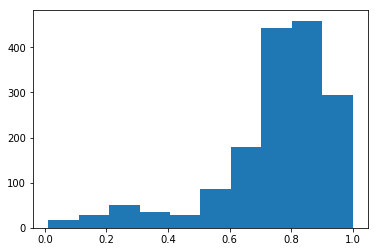

In [11]:
plt.hist(result_by_wells_frame["Acc"])

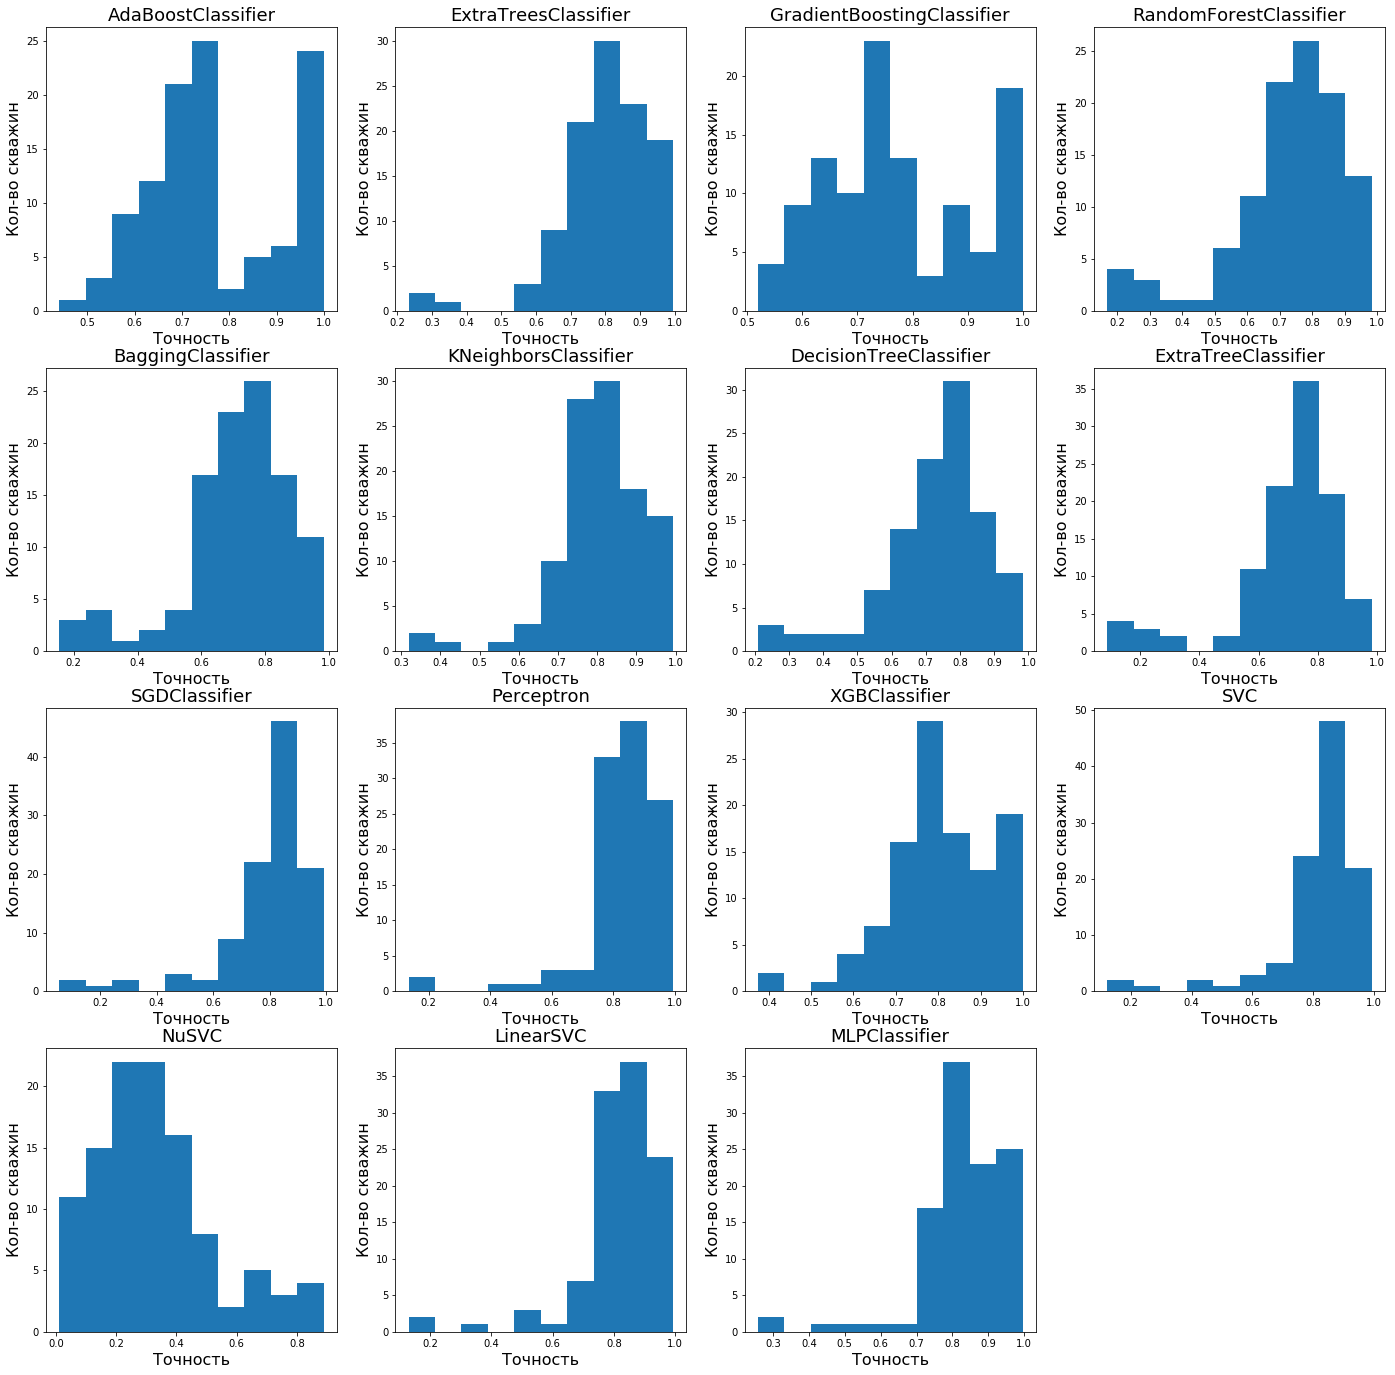

In [12]:
plt.subplots(figsize=(24,24))
plot_num = 0
for al in MLA:
    plot_num+=1
    plt.subplot(4, 4, plot_num)
    plt.hist(result_by_wells_frame[result_by_wells_frame["MLA Name"]==al.__class__.__name__]["Acc"])
    plt.title(al.__class__.__name__, fontsize=18)
    plt.ylabel("Кол-во скважин", fontsize=16)
    plt.xlabel("Точность", fontsize=16) 

In [21]:
r_frame = pd.DataFrame(columns=["Alg", "Mean", "Std*3"])
row_index = 0
for al in MLA:
    buf = result_by_wells_frame[result_by_wells_frame["MLA Name"]==al.__class__.__name__];
    r_frame.loc[row_index, "Alg"]= al.__class__.__name__
    r_frame.loc[row_index, "Mean"]= buf["Acc"].mean()
    r_frame.loc[row_index, "Std*3"]= buf["Acc"].std()
    row_index = row_index + 1
r_frame.sort_values(by=['Mean'])

,Alg,Mean,Std*3
12,NuSVC,0.326984,0.199265
7,ExtraTreeClassifier,0.699206,0.186389
4,BaggingClassifier,0.709825,0.175045
6,DecisionTreeClassifier,0.723322,0.154546
3,RandomForestClassifier,0.727287,0.173611
0,AdaBoostClassifier,0.769521,0.146228
2,GradientBoostingClassifier,0.773262,0.134646
8,SGDClassifier,0.789811,0.172834
5,KNeighborsClassifier,0.80188,0.117094
1,ExtraTreesClassifier,0.802129,0.133246
